# <center>Generalized uniform scenario - Numerical integration</center>

In this notebook we use the methods developped in the notebook "Generalized uniform scenario - Methods"
in a specific framework to compute expected utilities using numerical integration.

## <center>Framework</center>

We consider two types of agents : 
- **Strong agent** : its value is drawn according to Beta$(\alpha,1)$, its average value is $\frac{\alpha}{\alpha+1}$
- **Weak agent** : its value is drawn according to Unif$[0,1]$, its average value is $\frac{1}{2}$

There are $k_s$ strong agents and $k_w$ weak agents and we are comparing the following scenarios :

1. $1+k_w$ bidders participates at a first price auction where : 
    - The first bidder is a coalition of  $k_s$ strong agents
    - The $k_w$ other bidders are weak agents acting individually
    
    
2. $1+1+k_w$  bidders participates at a first price auction where :
    - The first bidder is a coalition of  $k_s-1$ strong agents
    - The second bidder is a strong agent.
    - The $k_w$ other bidders are  weak agents action individually.
    
The second scenario represents a defection of a strong individual from the coalition of the first scenario. The goal of these expriments is to know whether this defection is profitable or not. To this end, for both scenarios, we compute the expected utility of each agent using the numerical integration toolbook : `scipy.integrate`


## <center>Maths?</center>

## <center>Python code</center>

### Imports, display and stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib.colors import SymLogNorm

from scipy import integrate

from tqdm import tqdm_notebook as tqdm 
import time

In [3]:
def array_to_f(x,x_,y_) :
    return y_[min(np.searchsorted(x_,x),len(x_)-1)]

def array_to_inverse_f(y,x_,y_) :
    return x_[min(np.searchsorted(y_,y),len(y_)-1)]

def f_to_array(f,x_,) :
    return np.array([f(x) for x in x_])

In [4]:
def bid1_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values1_'],v)/(method_out['N']+1)

def bid2_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values2_'],v)/(method_out['N']+1)

def bid3_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values3_'],v)/(method_out['N']+1)

In [6]:
def displayGU(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coalition $k_1={}$ vs Coalition $k_2={}$ vs Individuals $k_3={}$".format(out['k1'],out['k2'],out['k3']))
    
    plt.subplot(131)
    v_ = np.linspace(0,1,1001)
    
    if(out['k1']!=0): 
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta1_'],'b',label=r'$\delta_1$')
        plt.axhline(out['l1'],color='b',linestyle='--')
    if(out['k2']!=0): 
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta2_'],'r',label=r'$\delta_2$')
        plt.axhline(out['l2'],color='r',linestyle='--')
    if(out['k3']!=0): 
        plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta3_'],'g',label=r'$\delta_3$')
        plt.axhline(out['l3'],color='g',linestyle='--')
        
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    #plt.ylim((min(out['l2_star'],out['l1_star'])-0.1,max(out['l2_star'],out['l1_star'])+0.1))
    plt.title(r"Approximated functions : $\delta_i(t) = \lambda_i(t)/t$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    
    if(out['k1']!=0): 
        plt.plot(b_,out['values1_'],'b',label=r'$\lambda_1$')
        plt.plot(b_,out['l1']*b_,'b--')
    if(out['k2']!=0): 
        plt.plot(b_,out['values2_'],'r',label=r'$\lambda_2$')
        plt.plot(b_,out['l2']*b_,'r--')
    if(out['k3']!=0):
        plt.plot(b_,out['values3_'],'g',label=r'$\lambda_3$')
        plt.plot(b_,out['l3']*b_,'g--')
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)
    if(out['k1']!=0): 
        plt.plot(v_,[bid1_f(v,out) for v in v_],'b',label=r"$\phi_1$")
        plt.plot(v_,1/out['l1']*v_,'b--')
    if(out['k2']!=0) :
        plt.plot(v_,[bid2_f(v,out) for v in v_],'r',label=r"$\phi_2$")
        plt.plot(v_,1/out['l2']*v_,'r--')
    if(out['k3']!=0):
        plt.plot(v_,1/out['l3']*v_,'g--')
        plt.plot(v_,[bid3_f(v,out) for v in v_],'g',label=r"$\phi_3$")
        
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

### Main methods

In [7]:
def shootGU(tstar,k1,k2,k3,N=10_000,correct=True) :
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)
    delta3_ = np.zeros(N+2)
    
    l1 = (1+1/(k2+k3))*(k1!=0)
    l2 = (1+1/(k1+k3))*(k2!=0)
    l3 = (1+1/(k1+k2+k3-1))*(k3!=0)
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1;    output['l2'] = l2;    output['l3'] = l3;
    output['k1'] = k1;    output['k2'] = k2;    output['k3'] = k3;
    
    eps_f = lambda i : np.sqrt((delta1_[i]-l1)**2+(delta2_[i]-l2)**2+(delta3_[i]-l3)**2)
    
    delta1_[N+1] = 1/tstar*(k1!=0)
    delta2_[N+1] = 1/tstar*(k2!=0)
    delta3_[N+1] = 1/tstar*(k3!=0)
    
    d1 = 0; d2 = 0; d3 = 0;
    d1p = 0; d2p = 0;  d3p = 0;
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
        tjm1 = tstar*(j-1)/(N+1)

        d1 = delta1_[j]
        d2 = delta2_[j]
        d3 = delta3_[j]
        
        #A = np.array([[0,k2*d3,k3*d2],
        #      [k1*d3,0,k3*d1],
        #      [k1*d2*d3,k2*d1*d3,(k3-1)*d1*d2]])
        #y = np.array([d2*d3/tj*( 1/(d1-1)-k2-k3 ),
        #              d1*d3/tj*( 1/(d2-1)-k1-k3 ),
        #              d1*d2*d3/tj*( 1/(d3-1) -k1-k2-k3+1) ])
        #x = np.linalg.solve(A,y)
        #d1p = x[0]; d2p = x[1]; d3p = x[2]

        #A = np.array([[0 , tj*(d1-1)*k2*d3 , tj*(d1-1)*k3*d2],
        #          [tj*(d2-1)*k1*d3 , 0 , tj*(d2-1)*k3*d1] ,
        #          [tj*(d3-1)*k1*d2*d3 , tj*(d3-1)*k2*d1*d3 , tj*(d3-1)*(k3-1)*d1*d2]])
        #y = np.array([d2*d3*( 1-(d1-1)*(k2+k3) ), d1*d3*( 1-(d2-1)*(k1+k3) ), d1*d2*d3*( 1-(d3-1)*(k1+k2+k3-1) )])
        #x = np.linalg.solve(A,y)
        #d1p = x[0]; d2p = x[1]; d3p = x[2]
        
        if(k1 != 0 and k2 != 0) :
            d1p = d1/(tj*k1) * ( (1-k3/(k3+1))/(d2-1) - k3/((k3+1)*(d1-1)) +k3/((k3+1)*(d3-1)) -k1 )
            d2p = d2/(tj*k2) * ( (1-k3/(k3+1))/(d1-1) - k3/((k3+1)*(d2-1)) +k3/((k3+1)*(d3-1)) -k2 )
            d3p = d3/(tj*(k3+1)) * ( 1/(d1-1) +1/(d2-1) -1/(d3-1) -k3-1 )
        if(k1 == 0 and k2 != 0) :
            d2p = d2/(tj*k2) * ( 1/(d3-1)-(k3-1)/(k3*(d2-1)) -k2 )
            d3p = d3/(tj*k3) * (1/(d2-1)-k3)
        if(k2 == 0 and k3 != 0) :
            d1p = d1/(tj*k1) * ( 1/(d3-1)-(k3-1)/(k3*(d1-1)) -k1 )
            d3p = d3/(tj*k3) * (1/(d1-1)-k3)
        
        delta1_[j-1] = d1+(tjm1-tj)*d1p
        delta2_[j-1] = d2+(tjm1-tj)*d2p
        delta3_[j-1] = d3+(tjm1-tj)*d3p
        
        if(output['breakpoint'] == 0 and eps_f(j-1) > eps_f(j) ) :
            output['breakpoint'] = j
            if(correct) :
                break

    output['eps_star'] = eps_f(output['breakpoint'])
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        delta3_[:ind+1] = np.linspace(l3,delta3_[ind],ind+1)
        
    output['delta1_'] = delta1_ ;   output['delta2_'] = delta2_ ;   output['delta3_'] = delta3_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    output['values3_']=np.linspace(0,tstar,N+2)*delta3_
    
    return output

In [8]:
def iterateGU(k1,k2,k3,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    l1 = (1+1/(k2+k3))*(k1!=0)
    l2 = (1+1/(k1+k3))*(k2!=0)
    l3 = (1+1/(k1+k2+k3-1))*(k3!=0)
    
    a = 1/max(l1,l2,l3)
    b = 1/np.min(np.where(np.equal([l1,l2,l3],0),np.inf,[l1,l2,l3]))   
                 
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = shootGU(x_1,k1,k2,k3,N=N,correct=correct)
    
    x_2 = a + tau*(b-a)
    f_2 = shootGU(x_2,k1,k2,k3,N=N,correct=correct)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = shootGU(x_2,k1,k2,k3,N=N,correct=correct)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = shootGU(x_1,k1,k2,k3,N=N,correct=correct)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(f_1['eps_star']<f_2['eps_star']) :
            print("tstar :",f_1['tstar'])
        else :
            print("tstar :",f_2['tstar'])
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
            
    if(f_1['eps_star']<f_2['eps_star']) :
        if(display_graphs) :
            displayGU(f_1)
        return f_1
    else :
        if(display_graphs) :
            displayGU(f_2)
        return f_2

### Scenarios

In [9]:
def scenarioGU_1(ks,kw,alpha,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    k1 = ks*alpha
    k2 = 0
    k3 = kw
    
    out = iterateGU(k1,k2,k3,eps=eps,nb_eval_max=nb_eval_max,N=N,show_msg=show_msg,display_graphs=display_graphs,correct=correct)
    
    b_ = np.linspace(0,out['tstar'],N+2)
    
    v1 = lambda b:array_to_f(b,b_,out['values1_'])
    #v2 = lambda b:array_to_f(b,b_,out['values2_'])
    v3 = lambda b:array_to_f(b,b_,out['values3_'])
    
    b1 = lambda v:array_to_inverse_f(v,b_,out['values1_'])
    #b2 = lambda v:array_to_inverse_f(v,b_,out['values2_'])
    b3 = lambda v:array_to_inverse_f(v,b_,out['values3_'])
    
    integrand_coal = lambda v : (v-b1(v)) * v3(b1(v))**k3 * k1*v**(k1-1)
    integrand_ext = lambda v : (v-b3(v)) * v1(b3(v))**k1 * k3*v**(k3-1)
    
    res = {}
    res['coal_sum'] = integrate.quad(integrand_coal, 0, 1, limit=2000, epsabs=10**-11,epsrel=10**-11)[0]
    res['coal_ind'] = res['coal_sum']/ks
    
    res['ext_sum'] = integrate.quad(integrand_ext, 0, 1, limit=2000, epsabs=10**-11,epsrel=10**-11)[0]
    res['ext_ind'] = res['ext_sum']/kw
    return res

In [10]:
def scenarioGU_2(ks,kw,alpha,eps=10**-4,nb_eval_max=100,N=10_000,show_msg=False,display_graphs=False,correct=True) :
    k1 = (ks-1)*alpha
    k2 = 1*alpha
    k3 = kw
    
    out = iterateGU( k1, k2, k3, eps=eps,nb_eval_max=nb_eval_max,N=N,show_msg=show_msg,display_graphs=display_graphs,correct=correct)
    
    b_ = np.linspace(0,out['tstar'],N+2)
        
    v1 = lambda b:array_to_f(b,b_,out['values1_'])
    v2 = lambda b:array_to_f(b,b_,out['values2_'])
    v3 = lambda b:array_to_f(b,b_,out['values3_'])
    
    b1 = lambda v:array_to_inverse_f(v,b_,out['values1_'])
    b2 = lambda v:array_to_inverse_f(v,b_,out['values2_'])
    b3 = lambda v:array_to_inverse_f(v,b_,out['values3_'])
    
    integrand_coal = lambda v : (v-b1(v)) * v2(b1(v))**k2 * v3(b1(v))**k3 * k1*v**(k1-1)
    integrand_strong = lambda v : (v-b2(v)) * v1(b2(v))**k1 * v3(b2(v))**k3 *  k2*v**(k2-1)
    integrand_ext = lambda v : (v-b3(v)) * v1(b3(v))**k1 * v2(b3(v))**k2 * k3*v**(k3-1)
    
    res = {}
    res['coal_sum'] = integrate.quad(integrand_coal, 0, 1, limit=2000, epsabs=10**-11,epsrel=10**-11)[0]
    res['coal_ind'] = res['coal_sum']/(ks-1)
    
    res['strong_ind'] = integrate.quad(integrand_strong, 0, 1, limit=2000, epsabs=10**-11,epsrel=10**-11)[0]
    
    res['ext_sum'] = integrate.quad(integrand_ext, 0, 1, limit=2000, epsabs=10**-11,epsrel=10**-11)[0]
    res['ext_ind'] = res['ext_sum']/kw
    return res

## <center>Tests</center>

In [20]:
m_ = np.arange(2,101)

for m in tqdm(m_) :
    shootGU((m-1)/m,1,0,m-1);#,show_msg=True,display_graphs=True);

In [19]:
n = 10
k_ = np.arange(1,n)

for k in tqdm(k_) :   
    iterateGU(k,n-k,0,eps=10**-5)#,display_graphs=True,show_msg=True)

In [9]:
scores_ = {}

#### [Marshall1994] Table III page 211 : Coalition vs Individuals
$\rightarrow$ Same results found with the previous method.

In [23]:
n = 5
k_ = np.arange(1,n)

scores_[n] = {}

for k in tqdm(k_) :   
    
    scores_[n][k] = {1:{}, 2:{}}
    
    res = scenarioGU_1(k,n-k,1,eps=10**-8)
    scores_[n][k][1]['coal_ind'] = res['coal_ind']
    scores_[n][k][1]['ext_ind'] = res['ext_ind']
    
print("New approx. : Coalition vs Individuals, n =", n)
for k in k_ :
    print("k {} | in {:.10f} | out {:.10f}".format(k,scores_[n][k][1]['coal_ind'],scores_[n][k][1]['ext_ind']))

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



New approx. : Coalition vs Individuals, n = 5
k 1 | in 0.0333333320 | out 0.0333274309
k 2 | in 0.0349836630 | out 0.0371535677
k 3 | in 0.0406771198 | out 0.0486479806
k 4 | in 0.0568194232 | out 0.0856531160


In [30]:
file_ = pickle.load(open("scenarios_.pickle",'rb'))

print("Old approx : Coalition vs Individuals, n =", n)
for k in k_ :
    print("k {} | in {:.10f} | out {:.10f}".format(k,file_[n][k][3]['in'],file_[n][k][3]['out']))

Old approx : Coalition vs Individuals, n = 5
k 1 | in 0.0333333324 | out 0.0333274309
k 2 | in 0.0349836630 | out 0.0371535677
k 3 | in 0.0406771199 | out 0.0486479806
k 4 | in 0.0568194233 | out 0.0856531157


## <center> Large test</center>

For different strength values $\alpha=\frac{1}{19}, \frac{1}{9}, \frac{1}{4}, \frac{1}{2}, 1, 3, 9$ which corresponds to the strong agents with average values of : $\frac{1}{20},\frac{1}{10}, \frac{1}{5}, \frac{1}{3}, \frac{1}{2}, \frac{3}{4}$. (...)

In [11]:
#res_ = {}
alpha_ = [1/19,1/9,1/4,1/2,1,3,9]
n_ = np.arange(3,16)

In [425]:
alpha_ = [1/19,1/9,1/4,1/2,1,3,9]
n_ = np.arange(3,16)

for alpha in tqdm(alpha_) :
    res_[alpha] = np.ones((len(n_),n_[-1]-2))*np.nan
    for n in tqdm(n_) :
        for ks in np.arange(2,n) :
            res_[alpha][n-3][ks-2] = scenarioGU_1(ks,n-ks,alpha,eps=10**-8)['coal_ind']-scenarioGU_2(ks,n-ks,alpha,eps=10**-8)['strong_ind']

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Use

In [430]:
#pickle.dump(res_,open("GU_defection_profit_eps8.pickle","wb"))

### Loading pickle

In [5]:
res_ = pickle.load(open("GU_defection_profit_eps8.pickle","rb"))
alpha_ = np.array([1/19,1/9,1/4,1/2,1,3,9])
print(alpha_)
print(alpha_/(alpha_+1))
n_ = np.arange(3,16)

[0.05263158 0.11111111 0.25       0.5        1.         3.
 9.        ]
[0.05       0.1        0.2        0.33333333 0.5        0.75
 0.9       ]


In [52]:
#emin = [np.floor(np.log10(np.min(np.where(np.isnan(res_[alpha]),np.inf,np.abs(res_[alpha]))))) for alpha in alpha_]
emin = -8#min(emin)

#emax = [np.ceil(np.log10(np.max(np.where(np.isnan(res_[alpha]),-np.inf,np.abs(res_[alpha]))))) for alpha in alpha_]
emax = -1.0#max(emax)

cbar_ticks = np.zeros(1)
cbar_ticks = np.append(-np.flip(np.power(10,np.arange(emin,emax+1))),cbar_ticks)
cbar_ticks = np.append(cbar_ticks,np.power(10,np.arange(emin,emax+1)))
print(cbar_ticks)

[-1.e-01 -1.e-02 -1.e-03 -1.e-04 -1.e-05 -1.e-06 -1.e-07 -1.e-08  0.e+00
  1.e-08  1.e-07  1.e-06  1.e-05  1.e-04  1.e-03  1.e-02  1.e-01]


In [60]:
tmp = [r"$-10^{{{:d}}}$".format(i) for i in np.flip(range(emin,np.int(emax)+1))]+["0"]+[r"$10^{{{:d}}}$".format(i) for i in range(emin,np.int(emax)+1)]
cbar_ticks_labels = np.where(np.arange(len(cbar_ticks))%2==0,tmp,r'')
print(cbar_ticks_labels)
del tmp

['$-10^{-1}$' '' '$-10^{-3}$' '' '$-10^{-5}$' '' '$-10^{-7}$' '' '0' ''
 '$10^{-7}$' '' '$10^{-5}$' '' '$10^{-3}$' '' '$10^{-1}$']


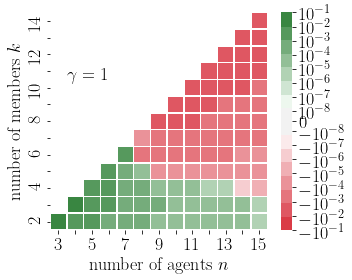

In [79]:
i = 1
plt.figure(figsize=(5,5*0.8))

for alpha in [1] :
    #plt.subplot(1,2,i)
    
    flipped = np.flip(np.transpose(res_[alpha]),axis=0)
    
    sns.heatmap(flipped,
                xticklabels=xtick_labels,yticklabels=ytick_labels,
                vmin = -10**emax, vmax=10**emax,
                mask=np.isnan(flipped),center=0,
                norm=SymLogNorm(linthresh=10**emin),
                cbar_kws={"ticks": cbar_ticks},
                cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
                square=True,linewidths=.5)
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels(cbar_ticks_labels)
    
    plt.text(1,4,r"$\gamma=1$")
    plt.xlabel(r"number of agents $n$")
    plt.ylabel(r"number of members $k$")
    i=i+1

plt.savefig("defection_loss_sym.png")
plt.show()

In [21]:
alpha_

[0.05263157894736842, 0.1111111111111111, 0.25, 0.5, 1, 3, 9]

In [149]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size" : 20
})

In [10]:
#sns.set(font_scale=1.5)

In [8]:
xtick_labels = np.where(np.arange(len(n_))%2==0,n_,"")
ytick_labels = np.where(np.arange(len(n_))%2==0,np.flip(n_-1),"")

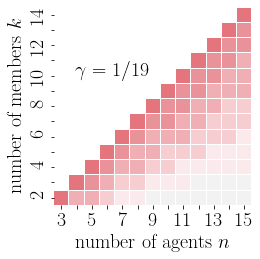

In [155]:
i=1

alpha = alpha_[0]

plt.figure(figsize=(5,5*0.8))#(figsize=(15/2,12/2))
    
flipped = np.flip(np.transpose(res_[alpha]),axis=0)

ax = sns.heatmap(flipped,
            xticklabels=xtick_labels,yticklabels=ytick_labels,
            vmin = -10**emax, vmax=10**emax,
            mask=np.isnan(flipped),center=0,
            norm=SymLogNorm(linthresh=10**emin),
            cbar=False,
            #cbar_kws={"ticks": cbar_ticks},
            cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
            square=True,linewidths=.05)

#cbar = ax.collections[0].colorbar
#cbar.set_ticklabels(cbar_ticks_labels)
plt.text(1.4,4.5,text_[i-1])
plt.xlabel(r"number of agents $n$")
plt.ylabel(r"number of members $k$")
plt.tight_layout()

plt.savefig("defection_loss_asym_{}.png".format(i))
plt.show()
i=i+1

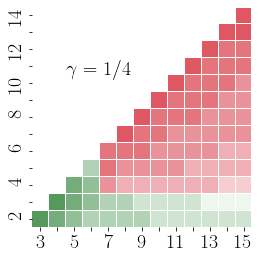

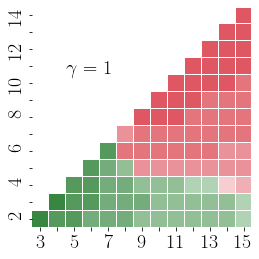

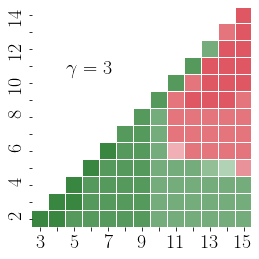

In [153]:
i=2
text_ = [r"$\gamma=1/19$",r"$\gamma=1/4$",r"$\gamma=1$",r"$\gamma=3$",r"$\gamma=9$"]
for alpha in [alpha_[2],alpha_[4],alpha_[-2]] :
    plt.figure(figsize=(5,5*0.8))#(figsize=(15/2,12/2))
    
    flipped = np.flip(np.transpose(res_[alpha]),axis=0)
    
    ax = sns.heatmap(flipped,
                xticklabels=xtick_labels,
                yticklabels=ytick_labels,
                vmin = -10**emax, vmax=10**emax,
                mask=np.isnan(flipped),center=0,
                norm=SymLogNorm(linthresh=10**emin),
                cbar=False,
                #cbar_kws={"ticks": cbar_ticks},
                cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
                square=True,linewidths=.05)
    
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticklabels(cbar_ticks_labels)
    plt.text(2,4,text_[i-1])
    #plt.xlabel(r"$n$")
    #plt.xlabel(r"number of agents $n$")
    #plt.ylabel(r"number of members $k$")
    plt.tight_layout()
    
    plt.savefig("defection_loss_asym_{}.png".format(i))
    plt.show()
    i=i+1

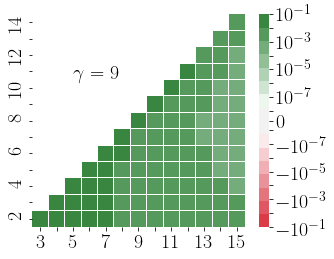

In [152]:
i=5
alpha = alpha_[-1]
plt.figure(figsize=(5,5*0.8))#(figsize=(15/2,12/2))

flipped = np.flip(np.transpose(res_[alpha]),axis=0)

ax = sns.heatmap(flipped,
            xticklabels=xtick_labels,
            yticklabels=ytick_labels,
            vmin = -10**emax, vmax=10**emax,
            mask=np.isnan(flipped),center=0,
            norm=SymLogNorm(linthresh=10**emin),
            #cbar=False,
            cbar_kws={"ticks": cbar_ticks},
            cmap=sns.diverging_palette(10,130,sep=50,n=16,as_cmap=False),#,s=85,l=53,sep=50,as_cmap=False,n=16),
            square=True,linewidths=.05)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(cbar_ticks_labels)
plt.text(2.5,4,text_[i-1])
plt.xlabel(" ")#plt.xlabel(r"number of agents $n$")
#plt.ylabel(r"number of members $k$")
plt.tight_layout()

plt.savefig("defection_loss_asym_{}.png".format(i))
plt.show()
i=i+1